<center><h1> K-means Clustering Model on Facebook Live Sellers in Thailand Data Set </h1></center> 

<center><h4> Nyasha M, 28 Apr 2021 </h4></center>
<p>&nbsp;</p>

**Background:**
This dataset consists of 7050 Facebook posts of various types (live video, photos, status updates, links) from the Facebook pages of 10 Thai fashion and cosmetics retail sellers between March 2012 and June 2018. 

Each Facebook post had its engagement metrics (coonsisting of shares, comments, likes, or emoji reactions--namely, “love”, “wow”, “haha”, “sad” and “angry”) recorded into the dataset, along with a timestamp of when each engagement occurred.

The dataset came from the following webpage at the University of California Irvine (UCI): https://archive.ics.uci.edu/ml/datasets/Facebook+Live+Sellers+in+Thailand.

**Objective:**
The goal of this notebook was to determine if the Facebook posts of the sellers could be clustered in some way into distinct categories, such as by the type of media they posted, the types of engagement they generated from Facebook users, or by the year/month that the posts were made.

---
**Citation:**
Nassim Dehouche and Apiradee Wongkitrungrueng. Facebook Live as a Direct Selling Channel, 2018, Proceedings of ANZMAC 2018: The 20th Conference of the Australian and New Zealand Marketing Academy. Adelaide (Australia), 3-5 December 2018.

---
### Data Exploration and Pre-processing

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sc

# Modeling
import sklearn.preprocessing as preprocess
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans as kmeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster.silhouette import SilhouetteVisualizer, silhouette_visualizer

In [4]:
# Change plotting style.
plt.style.use('bmh') 

Let's first load and preview our dataset.

In [26]:
# load the dataset.
df = pd.read_csv("Live_20210128.csv")
df.head(3)

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN


In [92]:
len(df)

7050

The last 4 columns look like they all just consist of missing values. Is this true? Let's return the rows where the data is NOT missing, within the last 4 columns.

In [27]:
df[df.loc[:, 'Column1':'Column4'].isna().any(axis=1) == False]

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4


In [28]:
# Drop the last 4 columns as they only consist of missing data.
df = df.drop(df.iloc[:,-4:], axis=1)
df.head(4)

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0


photo     4288
video     2334
status     365
link        63
Name: status_type, dtype: int64


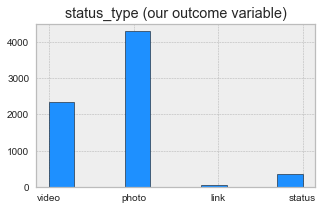

In [7]:
# status_type looks like a categorical variable. Is this true?
plt.figure(figsize=(5, 3))
df.status_type.hist(color='dodgerblue', edgecolor='black'), plt.title('status_type (our outcome variable)')
print(df.status_type.value_counts())

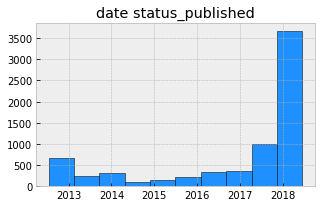

In [96]:
plt.figure(figsize=(5, 3))
df.status_published.astype('datetime64[s]').hist(color='dodgerblue', edgecolor='black'), plt.title('date status_published')
plt.show()

In [97]:
# How many columns are there excluding the first two columns (status and date)?
len(df.iloc[:,3:].columns)

9

Checking the distributions of the data in the 9 remaining columns.

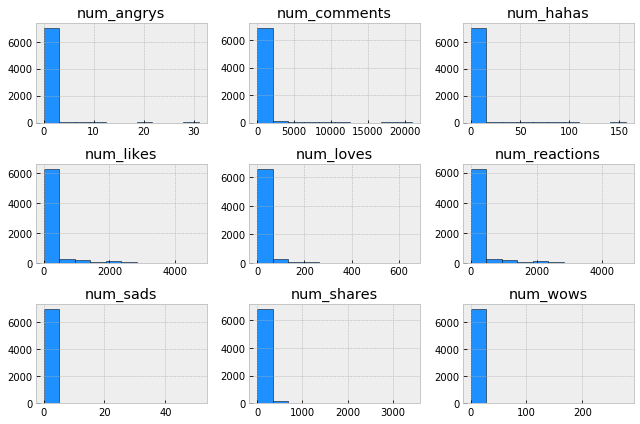

In [98]:
df[df.columns[3:]].hist(figsize=(9,6), color='dodgerblue', edgecolor='black')
plt.tight_layout()
plt.show()

Is there any other missing data in the dataset?

In [8]:
df[df.isna().any(axis=1)]

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys


Let's remove the `status_id` variable since it seems to be just an arbitrary feature. `status_published` seems like it might have some interesting data that we could try feeding into our clustering algorithm. However, extracting out the month number into dummies might be a bit problematic/cumbersome since 12 months would be a lot of dummies. Let's try extracting the years out of this variable for now, in case it might provide some interesting results.

In [29]:
df = df.drop(['status_id'], axis=1)

Extracting the years from `status_published` returned an error, because it appears that this variable isn't actually in a datetime format. Let's check the format:

In [30]:
df['status_published'].dtypes

dtype('O')

Odd. What happens if we try changing it into a datetime object? Would this work?

In [31]:
df['date'] = pd.to_datetime(df['status_published'], errors='coerce')

In [32]:
# It did, so now let's extract the years from our new datetime column of 'status_published'. We can also now drop
# the old timestamp columns that we don't need anymore.
df['year'] = df['date'].dt.year

df = df.drop(['status_published', 'date'], axis=1)

In [38]:
df.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,year
0,video,529,512,262,432,92,3,1,1,0,2018
1,photo,150,0,0,150,0,0,0,0,0,2018
2,video,227,236,57,204,21,1,1,0,0,2018
3,photo,111,0,0,111,0,0,0,0,0,2018
4,photo,213,0,0,204,9,0,0,0,0,2018


Now, K-means can only work on integers, so let's change `status_type` into an int-type feature. We'll also have to 'dummify' (or OneHotEncode) both our `status_type` and `year` features so that they don't adversely affect our K-means algorithm. When I say 'adversely affect', I mean that our categories cannot simply be in the form of ordinal values (i.e., 1, 2, 3... n), because if they are, then we won't get an accurate reading/sensical meaning of the 'distance' between the different levels of our features.

In [34]:
enc = preprocess.OneHotEncoder()
trans = enc.fit_transform(df[['status_type', 'year']]).toarray()
trans_df = pd.DataFrame(trans, columns = enc.get_feature_names(['status_type', 'year']))

In [35]:
df_merged = pd.concat([df, trans_df], axis=1)
df_merged.head(4)

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,...,status_type_photo,status_type_status,status_type_video,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,video,529,512,262,432,92,3,1,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,photo,150,0,0,150,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,video,227,236,57,204,21,1,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,photo,111,0,0,111,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
# df['status_link'], df['status_photo'], df['status_status'], df['status_video'] = [df_trans[0], df_trans[1], df_trans[2], df_trans[3]]

# df['year_2012'], df['year_2013'], df['year_2014'], df['year_2015']  = [df_trans[4], df_trans[5], df_trans[6], df_trans[7]]
# df['year_2016'], df['year_2017'], df['year_2018']  = [df_trans[8], df_trans[9], df_trans[10]]

In [37]:
# Now standardize the data. We only need to apply this onto the numerical, non-binary data (yes, I know we have counts)
clust_array = preprocess.StandardScaler().fit_transform(df_merged.loc[:, 'num_reactions':'num_angrys'])
df_merged.loc[:, 'num_reactions':'num_angrys'] = clust_array

df_merged = df_merged.drop(['status_type','year'],axis=1)
df_merged.head(3)

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_link,status_type_photo,status_type_status,status_type_video,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,0.646104,0.323350,1.686879,0.482727,1.983266,0.196196,0.076713,0.473570,-0.155748,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.173192,-0.252206,-0.304144,-0.144720,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.006738,0.013089,0.129017,-0.024571,0.206938,-0.033187,0.076713,-0.152587,-0.155748,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Model Deployment

Let's run our clustering model on the data across a range of test/dummy cluster numbers and record which number of clusters lead to the best division of data/distinct groups in the dataset. 

We will plot the sum of squared errors after each cluster (i.e., use the elbow method) as well as use the silhouette method to help us determine the ideal number of clusters for our dataset. The silhouette score ranges from -1 to 1; values closest to 1 are best and suggest that the clusters are fitting the outlines of the data (if clusters are indeed present) the best.

In [39]:
ss_dist = [np.nan]*10
silhouette_avg = [np.nan]*10
for k in range(2, 12):
    # random_state = set.seed to determine where cluster centroids are placed--allows for reproducible results
    k_means = kmeans(n_clusters = k, init = 'k-means++', n_init = 12, random_state = 2)  
    k_means.fit(df_merged)
    # Record sum of squared errors from each cluster iteration. Find the number of clusters that explains the greatest
    # amount of variation in the data, withoout overfitting.
    ss_dist[k-2] = k_means.inertia_
    
    # Get silhouette score from each attempted cluster number
    labels = k_means.labels_
    silhouette_avg[k-2] = silhouette_score(df_merged, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg[k-2])

For n_clusters = 2 The average silhouette_score is : 0.7343014721851232
For n_clusters = 3 The average silhouette_score is : 0.6045918297913099
For n_clusters = 4 The average silhouette_score is : 0.6071157755061909
For n_clusters = 5 The average silhouette_score is : 0.6095546861155134
For n_clusters = 6 The average silhouette_score is : 0.48931081109261515
For n_clusters = 7 The average silhouette_score is : 0.48615034379004896
For n_clusters = 8 The average silhouette_score is : 0.29486087907946695
For n_clusters = 9 The average silhouette_score is : 0.47573260612036433
For n_clusters = 10 The average silhouette_score is : 0.27335387087728147
For n_clusters = 11 The average silhouette_score is : 0.30278440026164805


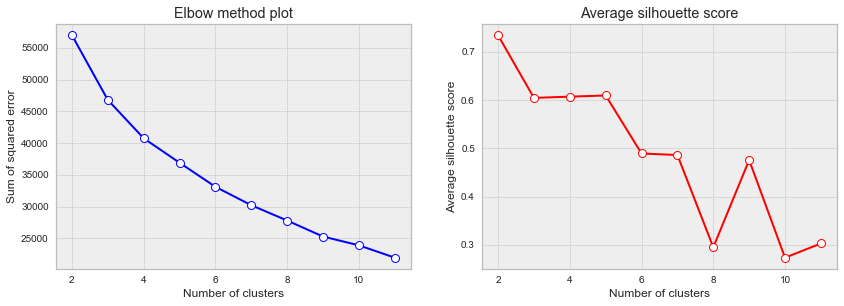

In [46]:
fig, axs = plt.subplots(1,2, figsize=(14, 4.5))
axs[0].plot(range(2,12), ss_dist, color='blue', marker='.', markerfacecolor='white', markeredgewidth=1, markersize=16)
axs[0].set_title('Elbow method plot')
axs[0].set_xlabel('Number of clusters'), axs[0].set_ylabel('Sum of squared error')

axs[1].plot(range(2,12), silhouette_avg, color='red', marker='.', markerfacecolor='white', markeredgewidth=1, markersize=16)
axs[1].set_title('Average silhouette score')
axs[1].set_xlabel('Number of clusters'), axs[1].set_ylabel('Average silhouette score')
plt.show()

2 and 5 clusters look a bit promising here. Let's try another silhouette plot of the contours of each cluster specifically to see how each individual cluster is performing.

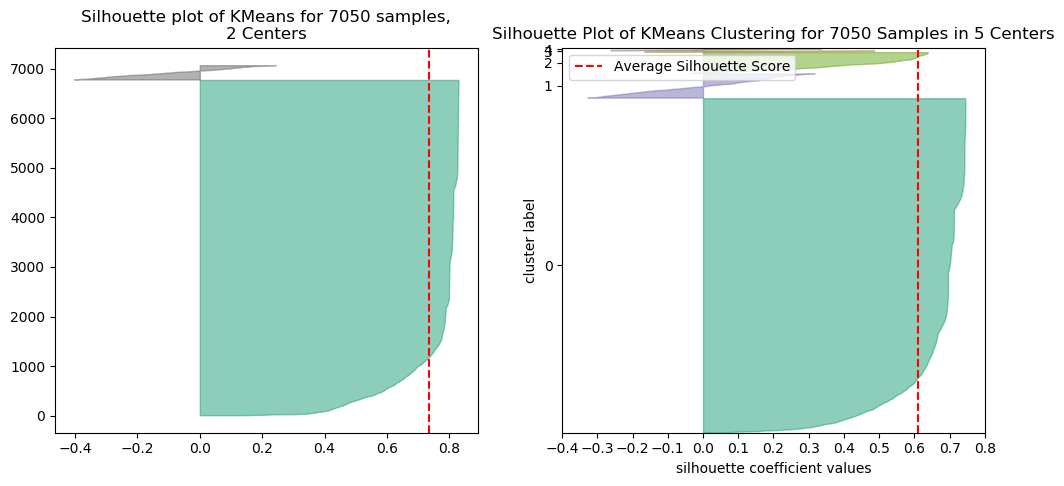

In [52]:
plt.style.use('default') 

fig, axs = plt.subplots(1,2, figsize=(12, 5))
k_means = SilhouetteVisualizer(kmeans(2, n_init = 12, random_state = 2), X=df_merged, ax = axs[0], colors='Dark2').fit(df_merged)
axs[0].set_title('Silhouette plot of KMeans for 7050 samples,\n2 Centers')

k_means = SilhouetteVisualizer(kmeans(5, n_init = 12, random_state = 2), ax = axs[1], colors='Dark2').fit(df_merged)
k_means.show()

We can see that it looks like n = 5 clusters might be best for clustering the data. Let's pick n = 5, then do some groupby commands to see if we can get a sense of whether the Facebook sellers might form any interesting groups/clusters.

In [54]:
# pick cluster number = 5, then save the resulting cluster labels that the algorithm suggests.
clust_num = 5

k_means = kmeans(init = "k-means++", n_clusters = clust_num, n_init = 12, random_state=2)
k_means.fit(df_merged)
labels = k_means.labels_

Now, let's apply the cluster labels from our algorithm back onto our original dataset.

In [55]:
df["clust_lab"] = labels
df.head(3)

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,year,clust_lab
0,video,529,512,262,432,92,3,1,1,0,2018,1
1,photo,150,0,0,150,0,0,0,0,0,2018,0
2,video,227,236,57,204,21,1,1,0,0,2018,0


### Results

How many observations belonged to each cluster?

In [56]:
df.groupby('clust_lab').size()

clust_lab
0    6169
1     445
2     386
3      17
4      33
dtype: int64

What are some characteristics of the clusters? Getting the **median** for all features except the `year`, and `status_type`.

In [57]:
df_median = df.groupby('clust_lab').median().iloc[:,:-1]
df_median['year_(mode)'] = df.groupby(['clust_lab'])['year'].agg(pd.Series.mode)
df_median['status_type_(mode)'] = df.groupby(['clust_lab'])['status_type'].agg(pd.Series.mode)
df_median

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,year_(mode),status_type_(mode)
clust_lab,,,,,,,,,,,
0,42,3,0,41,0,0,0,0,0,2018,photo
1,319,1566,311,226,92,2,3,1,1,2018,video
2,1771,18,2,1756,0,0,0,0,0,2015,photo
3,305,2,2,280,2,0,0,21,0,2016,photo
4,1411,1530,627,1097,281,103,11,1,2,2018,video


In [94]:
# # What proportion of reactions belonged to each cluster group (minus `years`, `status_type`)?
# df_freq = df.groupby('clust_lab').sum().iloc[:,:-1]
# df_freq = ((df_freq/df_freq.sum())*100).astype(float).round(2)
# df_freq['year_mode'], df_freq['status_type_(mode)'] = [df_median['year_(mode)'], df_median['status_type_(mode)']]
# df_freq

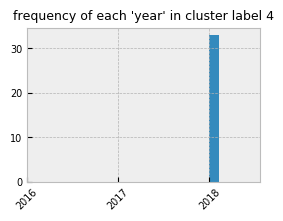

In [89]:
plt.style.use('bmh') 
xy_tick_size = 7

df['year'][df.clust_lab==4].hist(figsize=(3,2))
plt.xticks([2016, 2017, 2018], rotation=45, fontsize=xy_tick_size), plt.yticks(fontsize=xy_tick_size)
plt.title("frequency of each 'year' in cluster label 4", fontsize=9)
plt.show()

Frequency of different `status_types` per cluster label.

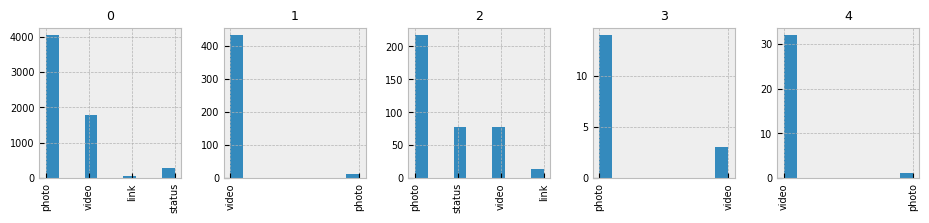

In [79]:
df_hist = df['status_type'].hist(figsize=(11,2), by = df['clust_lab'], layout=(1,5), xlabelsize=xy_tick_size, ylabelsize=xy_tick_size)
[x.title.set_size(9) for x in df_hist.ravel()]
plt.show()

### Conclusions

From looking at our aggregated dataframe, we can conclude that the Thai fashion and cosmetics sellers seemed to fall into 5 clusters:

* Cluster 0 posted mostly photos but tended to receive very little engagement on Facebook.


* Cluster 1 posted mostly videos which generally garnered a higher number of comments, but seemed to generate little else on Facebook.


* Cluster 2 posted mostly photos. They tended to gain a very high number of reactions and likes--the highest out of all sellers--on an average given post.


* Cluster 3 were very similar to Cluster 0. However they they tended to receive noticeably more reactions and likes than Cluster 0, along with the occasional sad reaction from their posts.


* Cluster 4 posted mostly videos, just like Cluster 1. However they tended to obtain a high number of reactions, comments, likes, and a moderately high number of shares, on an average given post. They tended to receive a high amount--and variety--of engagement overall, for their posts on Facebook.

### Bonus Data Exploration Area Below:

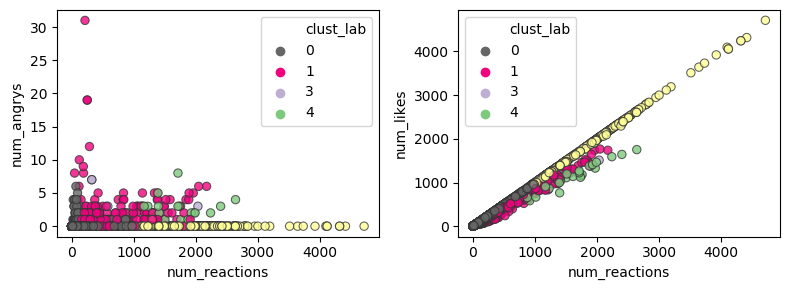

In [88]:
# Exploring some of the data.
plt.style.use('default') 
fig,axs = plt.subplots(1,2, figsize=(8,3))

sns.scatterplot('num_reactions', 'num_angrys', data=df, hue='clust_lab', palette='Accent_r', edgecolor='#353535', ax=axs[0], alpha=.8)
sns.scatterplot('num_reactions', 'num_likes', data=df, hue='clust_lab', palette='Accent_r', edgecolor='#353535', ax=axs[1], alpha=.8)
axs[0].legend(facecolor='white'), axs[1].legend(facecolor='white')
fig.tight_layout()